# Potato Plant Leaf Classification

**About the dataset**

The dataset is from kaggle viz. Plant Village

Link of the dataset-https://www.kaggle.com/datasets/arjuntejaswi/plant-village

This dataset has leaf images of tomato, pepper, potato. I would be only taking into consideration potato images for this project.

We are supposed to predict the potato plant's health from the leaf image of the plant. The dataset's images are classified into 3 categories.

1. Late_Blight(Unhealthy)
2. Early_Blight(Unhealthy)
3. Healthy

I have restructured the dataset into the below format:

Images_Floder
  CLASS A
    Class A images
  CLASS B
    Class B images
  .................

So that I can use the tf.keras.utils.image_dataset_from_directory for inputing the data.

In [ ]:
# Importing necessary libraries.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

In [ ]:
# Inputting the train dataset.

ds_train = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/Deep_learning_project-potato_classifier/Potato_Images',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = None,
    image_size = (256,256),
    shuffle = True,
    seed = 1,
    validation_split = 0.40,
    subset = 'training'
)



Found 2152 files belonging to 3 classes.
Using 1292 files for training.


In [ ]:
# Inputting the validation dataset.

ds_validation = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/Deep_learning_project-potato_classifier/Potato_Images',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = None,
    image_size = (256,256),
    shuffle = True,
    seed = 1,
    validation_split = 0.40,
    subset = 'validation'
)



Found 2152 files belonging to 3 classes.
Using 860 files for validation.


In [ ]:
# Taking a look at some of the images for each class.

for image in ds_validation:
  if image[1] == tf.constant(2,dtype = tf.int32):
    class_2_img = image
    break

for image in ds_validation:
  if image[1] == tf.constant(1,dtype = tf.int32):
    class_1_img = image
    break

for image in ds_validation:
  if image[1] == tf.constant(0,dtype = tf.int32):
    class_0_img = image
    break

The above is used to grap one image from each class.
* Image of class 2 means it is a **healthy** plant.
* Image of class 1 means it suffers from **Late_blight.**
* Image of class 0 means it suffers from **Early_blight.**

In [ ]:
# Storing class_names in a variable.

class_names = ds_validation.class_names
print(class_names)

['Early_blight', 'Late_blight', 'healthy']


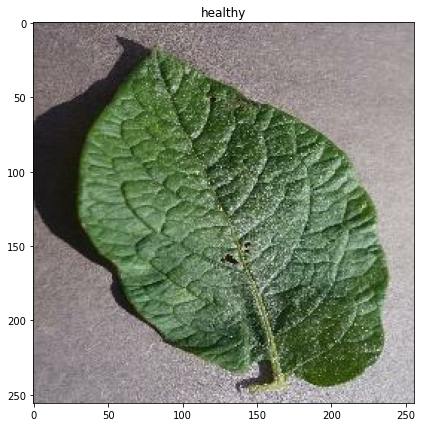

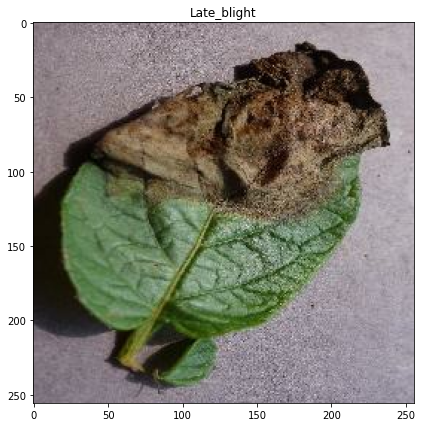

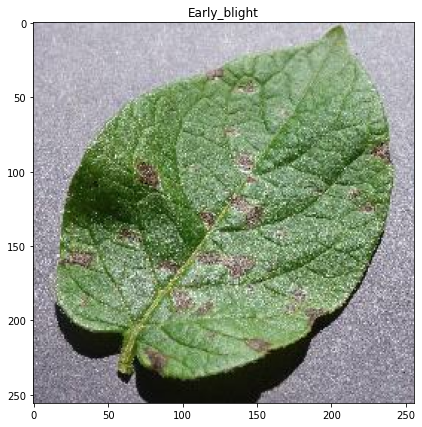

In [ ]:
# Showing images of various classes.
for image in [class_2_img,class_1_img,class_0_img]:
  fig = plt.figure(figsize = (10,7))
  ax = plt.gca()
  plt.imshow(image[0].numpy().astype('int32'))
  plt.title(class_names[image[1].numpy().astype('int32')])

In [ ]:
# Creating a testing set from traning set.

ds_validation = ds_validation.take(int(len(ds_validation) * .50))
ds_test = ds_validation.skip(int(len(ds_validation) * .50))
len_train, len_validation, len_test = len(ds_train), len(ds_validation), len(ds_test)
print(f'The number of samples for traning are {len_train}')
print(f'The number of samples for validation are {len_validation}')
print(f'The number of samples for test are {len_test}')

The number of samples for traning are 1292
The number of samples for validation are 430
The number of samples for test are 215


## Preprocessing 3 datasets.

In [ ]:
# Creating a function to normalize the images.

def normalize(img,label):
  return tf.cast(img,tf.float32) / 255.0, label

Normalizing ensures that the values of images lie between 0 and 1. This is done to expidite the training, evaluating process

In [ ]:
# Creating a function for data_augmentation.

def augment(image,label):
  tf.image.random_brightness(image,max_delta = 0.1)
  tf.image.random_contrast(image,lower = 0.1, upper = 0.2)
  tf.image.random_flip_left_right(image)
  return image,label

Data Augmentation is done to ensure that the model doesn't overfit. The CNN network usually overfits the data becasue of paucity of images.

In [ ]:
# Preprocessing ds_train.

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = ds_train.batch(64)
ds_train = ds_train.map(normalize,num_parallel_calls=10)
ds_train = ds_train.map(augment)
ds_train = ds_train.prefetch(AUTOTUNE)
ds_train = ds_train.cache()

In [ ]:
# Preprocessing ds_validation

ds_validation = ds_validation.batch(64)
ds_validation = ds_validation.map(normalize)
ds_validation = ds_validation.prefetch(AUTOTUNE)

In [ ]:
# Preprocessing ds_test

ds_test = ds_test.batch(64)
ds_test = ds_test.map(normalize)
ds_test = ds_test.prefetch(AUTOTUNE)

## Creating a model.

In [ ]:
# Building a model.

model = keras.Sequential()
model.add(layers.experimental.preprocessing.Resizing(256,256)),
model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape = (256,256,3))),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Conv2D(64,(3,3),activation = 'relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Conv2D(64, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Flatten()),
model.add(layers.Dense(64, activation='relu')),
model.add(layers.Dense(3,activation = 'softmax'))

In [ ]:
# Intializing a callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
     monitor='loss', factor=0.2,
     patience=5, min_lr=0.001
)


The above callback reduces the learning rate by a factor of 0.2 when the loss doesn't change for 5 consective epochs

In [ ]:
# Compling the model.

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'],
              optimizer = keras.optimizers.Adam())

In [ ]:
# Fitting the model to the data.

history_1 = model.fit(ds_train, epochs = 50, batch_size = 64, verbose = 2, callbacks = [reduce_lr])

Epoch 1/50
21/21 - 54s - loss: 0.9296 - sparse_categorical_accuracy: 0.4590 - lr: 0.0010 - 54s/epoch - 3s/step
Epoch 2/50
21/21 - 3s - loss: 0.8821 - sparse_categorical_accuracy: 0.4605 - lr: 0.0010 - 3s/epoch - 121ms/step
Epoch 3/50
21/21 - 3s - loss: 0.8338 - sparse_categorical_accuracy: 0.5488 - lr: 0.0010 - 3s/epoch - 119ms/step
Epoch 4/50
21/21 - 3s - loss: 0.7303 - sparse_categorical_accuracy: 0.6649 - lr: 0.0010 - 3s/epoch - 120ms/step
Epoch 5/50
21/21 - 3s - loss: 0.5801 - sparse_categorical_accuracy: 0.7353 - lr: 0.0010 - 3s/epoch - 121ms/step
Epoch 6/50
21/21 - 3s - loss: 0.5654 - sparse_categorical_accuracy: 0.7500 - lr: 0.0010 - 3s/epoch - 121ms/step
Epoch 7/50
21/21 - 3s - loss: 0.4045 - sparse_categorical_accuracy: 0.8406 - lr: 0.0010 - 3s/epoch - 121ms/step
Epoch 8/50
21/21 - 3s - loss: 0.2910 - sparse_categorical_accuracy: 0.8893 - lr: 0.0010 - 3s/epoch - 120ms/step
Epoch 9/50
21/21 - 3s - loss: 0.1763 - sparse_categorical_accuracy: 0.9389 - lr: 0.0010 - 3s/epoch - 120m

In [ ]:
# Checking out the summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        3

In [ ]:
# evaluating on the validation set.

model.evaluate(ds_validation)

7/7 [==============================] - 2s 135ms/step - loss: 0.0370 - sparse_categorical_accuracy: 0.9814


[0.03698929399251938, 0.9813953638076782]

Text(0.5, 1.0, 'accuracy at every epoch')

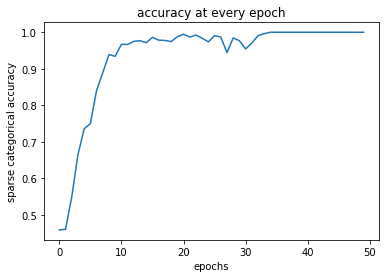

In [ ]:
# Let us plot the training accuraries at every epoch.

acc_at_epoch = history_1.history['sparse_categorical_accuracy']
plt.plot(acc_at_epoch)
plt.xlabel('epochs')
plt.ylabel('sparse categorical accuracy')
plt.title('accuracy at every epoch')

Text(0.5, 1.0, 'loss at every epoch')

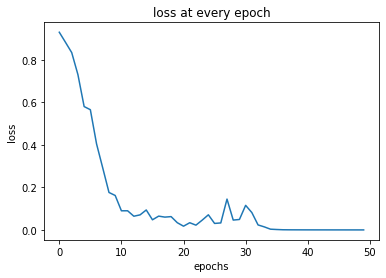

In [ ]:
# Let us plot the training loss at every epoch.

loss_at_epoch = history_1.history['loss']
plt.plot(loss_at_epoch)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss at every epoch')

Even though the training error is nill and the validation error is very low. I would be fine tuning a hyperparameters to see if I can reduce the validation error furthur.

## Tuning of Hyper-Parameters.

The parameters that I going to tune are the learning_rate and beta_1. Usually learning_rate lies between 0.0001 and 1 and beta_1 lies between 0.9 to 0.999.
I will be randomly picking the hyperparameter values because of the lack of compute I have.

### Tuning Model 1

In [ ]:
# Selecting 3 uniform random values for alpha 

tf.random.set_seed(5) # To ensure that the below code produces the same results all the time
alpha = tf.random.uniform((3,), minval = 0.0001, maxval = 1, seed = 10).numpy().tolist()
alpha = [round(num,4) for num in alpha]
print(f'The 3 random values for learning rate are {alpha}')

The 3 random values for learning rate are [0.0917, 0.9567, 0.0298]


In [ ]:
# Selecting 3 uniform random values for beta_1.


tf.random.set_seed(0)
beta_1 = tf.random.uniform((3,), minval = 0.9, maxval = 0.999, seed = 3).numpy().tolist()
beta_1 = [round(num,4) for num in beta_1]
print(f'The 3 random values for beta_1 are {beta_1}')

The 3 random values for beta_1 are [0.9317, 0.9685, 0.9735]


In [ ]:
# Creating a list of tuples for all the combination of hyper-parameters.

hyper_para = []
for i in alpha:
  for j in beta_1:
    hyper_para.append((i,j))

In [ ]:
# All the combination of hyper-parameters.
import random

random.seed(0)
print(f'The various combination of hyper-parameters are as follows {hyper_para}')
random_hyper_para = random.sample(hyper_para,2)   # From all the combination of values selection two random combinations 

The various combination of hyper-parameters are as follows [(0.0917, 0.9317), (0.0917, 0.9685), (0.0917, 0.9735), (0.9567, 0.9317), (0.9567, 0.9685), (0.9567, 0.9735), (0.0298, 0.9317), (0.0298, 0.9685), (0.0298, 0.9735)]


In [ ]:
# Creating a new model with changed hyper-parameters.

model_1 = keras.Sequential()
model_1.add(layers.experimental.preprocessing.Resizing(256,256)),
model_1.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape = (256,256,3))),
model_1.add(layers.MaxPooling2D((2, 2))),
model_1.add(layers.Conv2D(64,(3,3),activation = 'relu')),
model_1.add(layers.MaxPooling2D((2, 2))),
model_1.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_1.add(layers.MaxPooling2D((2, 2))),
model_1.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_1.add(layers.MaxPooling2D((2, 2))),
model_1.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_1.add(layers.MaxPooling2D((2, 2))),
model_1.add(layers.Flatten()),
model_1.add(layers.Dense(64, activation='relu')),
model_1.add(layers.Dense(3,activation = 'softmax'))

In [ ]:
# Compling the model.

model_1.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'],
              optimizer = keras.optimizers.Adam(learning_rate = random_hyper_para[0][0], beta_1 = random_hyper_para[0][1]))


In [ ]:
# Fitting the model

history_2 = model_1.fit(ds_train, epochs = 50, batch_size = 64, verbose = 2, callbacks = [reduce_lr])

Epoch 1/50
21/21 - 3s - loss: 147.2706 - sparse_categorical_accuracy: 0.4474 - lr: 0.0298 - 3s/epoch - 143ms/step
Epoch 2/50
21/21 - 2s - loss: 0.9769 - sparse_categorical_accuracy: 0.4690 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 3/50
21/21 - 2s - loss: 0.9001 - sparse_categorical_accuracy: 0.4257 - lr: 0.0298 - 2s/epoch - 115ms/step
Epoch 4/50
21/21 - 2s - loss: 0.8920 - sparse_categorical_accuracy: 0.4690 - lr: 0.0298 - 2s/epoch - 115ms/step
Epoch 5/50
21/21 - 2s - loss: 0.8916 - sparse_categorical_accuracy: 0.4365 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 6/50
21/21 - 2s - loss: 0.8906 - sparse_categorical_accuracy: 0.4288 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 7/50
21/21 - 2s - loss: 0.8911 - sparse_categorical_accuracy: 0.4257 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 8/50
21/21 - 2s - loss: 0.8911 - sparse_categorical_accuracy: 0.4311 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 9/50
21/21 - 2s - loss: 0.8912 - sparse_categorical_accuracy: 0.4257 - lr: 0.0298 - 2s/epoch - 1

In [ ]:
# evaluating on the validation set.

model_1.evaluate(ds_validation)

7/7 [==============================] - 2s 63ms/step - loss: 0.9216 - sparse_categorical_accuracy: 0.4651


[0.9216111302375793, 0.4651162922382355]

With alpha = 0.0298 and beta_1 = 0.9317, The model struggled to perform.
Lets try with the second batch of hyper-parameters.


Text(0.5, 1.0, 'accuraries at every epoch')

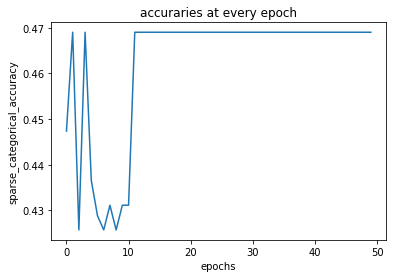

In [ ]:
# Plotting the loss and accuraries at every epoch.

plt.plot(history_2.history['sparse_categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('sparse_categorical_accuracy')
plt.title('accuraries at every epoch')

Text(0.5, 1.0, 'loss at every epoch')

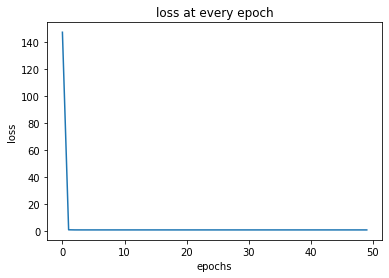

In [ ]:

plt.plot(history_2.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss at every epoch')

### Tuning Model 2

In [ ]:
# Creating a 3rd instance of the model.

model_2 = keras.Sequential()
model_2.add(layers.experimental.preprocessing.Resizing(256,256)),
model_2.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape = (256,256,3))),
model_2.add(layers.MaxPooling2D((2, 2))),
model_2.add(layers.Conv2D(64,(3,3),activation = 'relu')),
model_2.add(layers.MaxPooling2D((2, 2))),
model_2.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_2.add(layers.MaxPooling2D((2, 2))),
model_2.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_2.add(layers.MaxPooling2D((2, 2))),
model_2.add(layers.Conv2D(64, (3, 3), activation='relu')),
model_2.add(layers.MaxPooling2D((2, 2))),
model_2.add(layers.Flatten()),
model_2.add(layers.Dense(64, activation='relu')),
model_2.add(layers.Dense(3,activation = 'softmax'))

In [ ]:
# Compling the model.

model_2.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'],
              optimizer = keras.optimizers.Adam(learning_rate = random_hyper_para[1][0], beta_1 = random_hyper_para[1][1]))


In [ ]:
# Fitting the model

history_3 = model_2.fit(ds_train, epochs = 50, batch_size = 64, verbose = 2, callbacks = [reduce_lr])

Epoch 1/50
21/21 - 3s - loss: 275.5991 - sparse_categorical_accuracy: 0.4706 - lr: 0.0298 - 3s/epoch - 142ms/step
Epoch 2/50
21/21 - 2s - loss: 1.1317 - sparse_categorical_accuracy: 0.4435 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 3/50
21/21 - 2s - loss: 0.8998 - sparse_categorical_accuracy: 0.5062 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 4/50
21/21 - 2s - loss: 0.9236 - sparse_categorical_accuracy: 0.4551 - lr: 0.0298 - 2s/epoch - 113ms/step
Epoch 5/50
21/21 - 2s - loss: 0.9104 - sparse_categorical_accuracy: 0.4659 - lr: 0.0298 - 2s/epoch - 113ms/step
Epoch 6/50
21/21 - 2s - loss: 0.8948 - sparse_categorical_accuracy: 0.4714 - lr: 0.0298 - 2s/epoch - 113ms/step
Epoch 7/50
21/21 - 2s - loss: 0.8968 - sparse_categorical_accuracy: 0.4358 - lr: 0.0298 - 2s/epoch - 113ms/step
Epoch 8/50
21/21 - 2s - loss: 0.8886 - sparse_categorical_accuracy: 0.4946 - lr: 0.0298 - 2s/epoch - 114ms/step
Epoch 9/50
21/21 - 2s - loss: 0.8931 - sparse_categorical_accuracy: 0.4690 - lr: 0.0298 - 2s/epoch - 1

In [ ]:
# evaluating on the validation set.

model_2.evaluate(ds_validation)

7/7 [==============================] - 3s 71ms/step - loss: 0.8980 - sparse_categorical_accuracy: 0.4767


[0.8979960680007935, 0.4767441749572754]

Even at alpha = 0.0298 and beta_1 = 0.9735, the model is struggling to perform.
From looking at the accuraries of the 3 models We can conclude that the first model works well.

Text(0.5, 1.0, 'accuracy at every epoch')

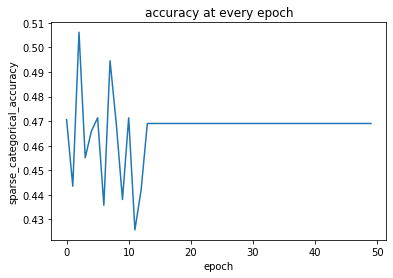

In [ ]:
# Plotting accuracies and losses at every epoch.

plt.plot(history_3.history['sparse_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('sparse_categorical_accuracy')
plt.title('accuracy at every epoch')

Text(0.5, 1.0, 'loss at every epoch')

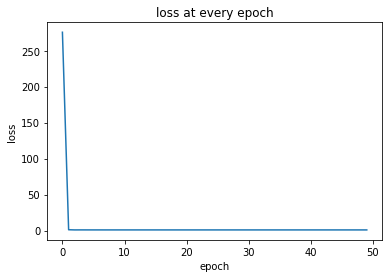

In [ ]:

plt.plot(history_3.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss at every epoch')

## Performing Error Analysis.

Error analysis is performed to understand whether the model has high bais(underfitting) or high variance(overfitting).

If the model has high bais, we can perform the following things:
  * Training a lot more.
  * changing the architecture of the model.
  * Adding more layers.

If the model has high variance, we can perform the following things:
  * Collect more data
  * Regularization, Dropout
  * changing the architecture of the model.

**Bayes_Error**: Bayes error rate is the lowest possible error rate for any classifier of a random outcome.I will be making an assumption that the bais error is zero.

**Note:** I will be performing my error analysis on the best model that I have got up until now.


Error analysis on 1st model(intialized as model).

Bayes error: 0
Training error: 1 - 1(acc I got when traning the model) = 0 (aviodable bais)
I will be substracting the acc with 1 because we need to calculate error.
Validation error = 1 - 0.9395 = 0.0605(Variance)

From the above error analysis we see that neither the variance or aviodalbe bais is low we can deploy the model as it is, but for learning purposes I will try to reduce the varinace further by adding regularization and dropout.

In [ ]:
# Building a model.

model_3 = keras.Sequential()
model_3.add(layers.experimental.preprocessing.Resizing(256,256)),
model_3.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape = (256,256,3))),
model_3.add(layers.MaxPooling2D((2, 2))),
model_3.add(layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer = regularizers.L2(0.01))),
model_3.add(layers.MaxPooling2D((2, 2))),
model_3.add(layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer = regularizers.L2(0.01))),
model_3.add(layers.MaxPooling2D((2, 2))),
model_3.add(layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer = regularizers.L2(0.01))),
model_3.add(layers.MaxPooling2D((2, 2))),
model_3.add(layers.Conv2D(64,(3,3),activation = 'relu',kernel_regularizer = regularizers.L2(0.01))),
model_3.add(layers.MaxPooling2D((2, 2))),
model_3.add(layers.Flatten()),
model_3.add(layers.Dropout(0.25))
model_3.add(layers.Dense(64, activation='relu')),
model_3.add(layers.Dense(3,activation = 'softmax'))

In [ ]:
# Compling the model.

model_3.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['sparse_categorical_accuracy'],
              optimizer = keras.optimizers.Adam())

In [ ]:
# Fitting the model

history_4 = model_3.fit(ds_train, epochs = 50, batch_size = 64, verbose = 2, callbacks = [reduce_lr])

Epoch 1/50
21/21 - 3s - loss: 2.6441 - sparse_categorical_accuracy: 0.4644 - lr: 0.0010 - 3s/epoch - 157ms/step
Epoch 2/50
21/21 - 2s - loss: 1.6607 - sparse_categorical_accuracy: 0.4837 - lr: 0.0010 - 2s/epoch - 118ms/step
Epoch 3/50
21/21 - 2s - loss: 1.1879 - sparse_categorical_accuracy: 0.5402 - lr: 0.0010 - 2s/epoch - 119ms/step
Epoch 4/50
21/21 - 2s - loss: 0.9165 - sparse_categorical_accuracy: 0.6989 - lr: 0.0010 - 2s/epoch - 119ms/step
Epoch 5/50
21/21 - 3s - loss: 0.7522 - sparse_categorical_accuracy: 0.7539 - lr: 0.0010 - 3s/epoch - 120ms/step
Epoch 6/50
21/21 - 2s - loss: 0.6394 - sparse_categorical_accuracy: 0.8034 - lr: 0.0010 - 2s/epoch - 119ms/step
Epoch 7/50
21/21 - 2s - loss: 0.5433 - sparse_categorical_accuracy: 0.8375 - lr: 0.0010 - 2s/epoch - 118ms/step
Epoch 8/50
21/21 - 2s - loss: 0.5814 - sparse_categorical_accuracy: 0.8127 - lr: 0.0010 - 2s/epoch - 118ms/step
Epoch 9/50
21/21 - 2s - loss: 0.5070 - sparse_categorical_accuracy: 0.8367 - lr: 0.0010 - 2s/epoch - 118

In [ ]:
# evaluating on the validation set.

model_3.evaluate(ds_validation)

7/7 [==============================] - 2s 63ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.9674


[0.1725194901227951, 0.9674418568611145]

Because we have adding dropout and regularization our performance on the validation set has improved a a bit.

Text(0.5, 1.0, 'accuracy at every epoch')

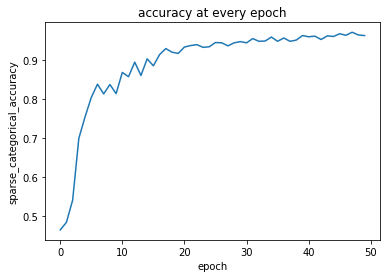

In [ ]:
# Plotting accuracies and losses at every epoch.

plt.plot(history_4.history['sparse_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('sparse_categorical_accuracy')
plt.title('accuracy at every epoch')

Text(0.5, 1.0, 'loss at every epoch')

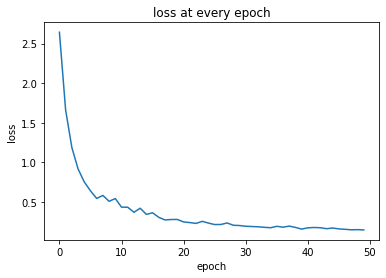

In [ ]:
plt.plot(history_4.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss at every epoch')

## Plotting the val_accuracies of all the 4 models.

In [ ]:
# Creating a data frame of all the val_accuracies of the models

import pandas as pd

val_acc = {'model':['model_0','model_1','model_2','model_3'],'val_acc':[0.9814,0.4651,0.4767,0.9674]}
val_acc_df = pd.DataFrame(val_acc)

Text(0.5, 1.0, 'val accuraries')

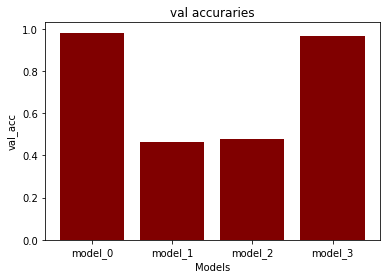

In [ ]:
# Plotting the val_accuracies.

plt.bar(val_acc_df['model'],val_acc_df['val_acc'],color = 'maroon')
plt.xlabel('Models')
plt.ylabel('val_acc')
plt.title('val accuraries')

From the bar chart we can observe that model_0,model_3 have the highest accuracy.
So I will evaluate model_0,model_3 the test data and decide which model to save

In [ ]:
# Evaluating model_3 on the test_data.

model_3.evaluate(ds_test)

4/4 [==============================] - 2s 143ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9488


[0.20645812153816223, 0.9488372206687927]

In [ ]:
# Evaluating model_0 on the test_data.

model.evaluate(ds_test)

4/4 [==============================] - 3s 62ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9860


[0.03835497424006462, 0.9860464930534363]

Since model_0 got the highest accuracy I will save model_0 

## Saving the model_3

In [ ]:
# Saving the model weights in the below path

model.save('/content/drive/MyDrive/Colab Notebooks/Deep_learning_project-potato_classifier/best_model')